In [1]:
# coding=utf-8
import os
import sys
import joblib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint

# 0 全局变量设置
# 输入输出路径
BASE_DIR = './'
Model_DIR = './'
#文本语料路径
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [2]:
def get_cnn_model(embedding_layer):
    ''' CNN Model '''
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    # 第一层卷积
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    # 第二层卷积
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    # 第三层卷积
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    # 全连接层
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    # 输出层
    model.add(tf.keras.layers.Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
    model.summary()
    return model

def get_cnn_lstm_model(embedding_layer):
    ''' CNN-LSTM Model '''
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    # 第一层卷积
    model.add(Conv1D(128, 5, activation='relu',padding='valid', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    # 第二层卷积
    model.add(Conv1D(128, 5, activation='relu',padding='valid', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    # 第三层卷积
    model.add(Conv1D(128, 5, activation='relu',padding='valid', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    # LSTM层
    model.add(LSTM(100))
    # 全连接层
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    # 输出层
    model.add(tf.keras.layers.Dense(20, activation='softmax'))
    # 优化器
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    model.summary()
    return model

def plot_history(history,title):
    ''' 训练过程绘制 '''
    fig, axs = plt.subplots(2)
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.4)
    plt.suptitle(title,fontsize=18)
    print("max(train_acc) =%.3f, max(val_acc) = %.3f"%
          (max(history.history["acc"]), 
           max(history.history["val_acc"])))
    # acc
    axs[0].plot(history.history["acc"], 'r', linewidth=3.0, label="train acc")
    axs[0].plot(history.history["val_acc"], 'b',linewidth=3.0, label="test acc")
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("acc")
    axs[0].legend(loc="lower right")

    # loss
    axs[1].plot(history.history["loss"], 'r', linewidth=3.0, label="train loss")
    axs[1].plot(history.history["val_loss"], 'b', linewidth=3.0, label="test loss")
    axs[1].set_ylabel("loss")
    axs[1].set_xlabel("epochs")
    axs[1].legend(loc="upper right")
    fig.savefig(title+'.png', dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

def save_model(model_name):
    model_path = os.path.join(Model_DIR, model_name+'.h5')
    model.save(model_path)
    print('Saved model to disk '+model_path)

def get_data():
    texts = []
    labels_index = {}
    labels = []
    for name in sorted(os.listdir(TEXT_DATA_DIR)):
        path = os.path.join(TEXT_DATA_DIR, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # skip header
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)
    print('Found %s texts.' % len(texts))
    return texts,labels

In [3]:
# 1 文本读取
texts,labels = get_data()

Found 19997 texts.


In [4]:
# 2 文本预处理
# 2.1 获取token解析器
token_result_path = 'token_result.pkl'
if os.path.exists(token_result_path):
    tokenizer = joblib.load(token_result_path)
else:
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(texts)
    joblib.dump(tokenizer, token_result_path)

# 2.2 文本序列化，label独热编码
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)  # 文本pad
labels = to_categorical(np.asarray(labels))  # 独热编码
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 2.3 随机数据，获取训练集和测试集
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]
print("train's shape",x_train.shape,y_train.shape)
print("test's shape",x_val.shape,y_val.shape)

Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
train's shape (15998, 1000) (15998, 20)
test's shape (3999, 1000) (3999, 20)


In [5]:
# 3 词嵌入层初始化
# 3.1 文本词向量编码
print('Indexing word vectors.')
embeddings_index = {}
with open(os.path.join(BASE_DIR, 'glove.6B.100d.txt'),'r',encoding='utf-8') as f: # 这是glove.6B.l00d.txt的词嵌入向量
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

# 3.2 获取文本的词向量
print('Preparing embedding matrix.')
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # 如果glove中不存在相应的词向量，则全为0
        embedding_matrix[i] = embedding_vector  # 从预训练模型的词向量到语料库的词向量映射

# 3.3 初始化词嵌入层
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("embedding_layer is ok")

Indexing word vectors.
Preparing embedding matrix.
embedding_layer is ok


In [6]:
# 4 模型checkpoint，中途训练效果提升, 则将文件保存, 每提升一次, 保存一次
# filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

Training model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 1

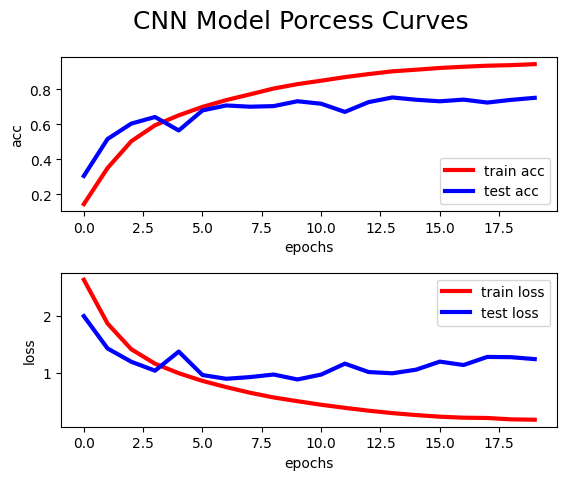

In [7]:
# 5 模型训练，以及性能比较
print('Training model.')
# 5.1 CNN模型
model = get_cnn_model(embedding_layer)
model_name = "CNN Model"
history=model.fit(x_train, y_train,
        batch_size=128,
        epochs=20,
        validation_data=(x_val, y_val))
plot_history(history,model_name+" Porcess Curves")
# save_model(model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 199, 128)          512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 128)          

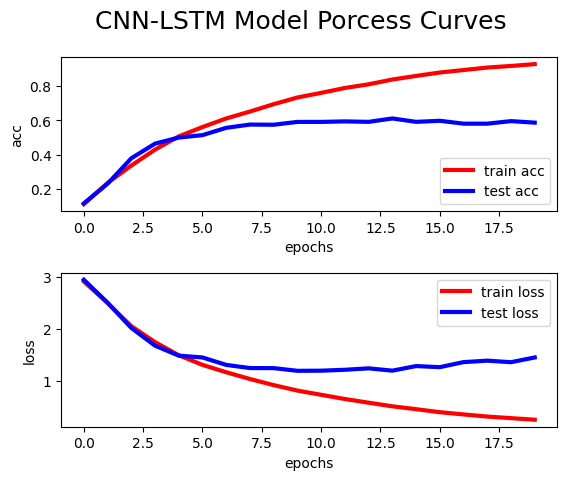

In [8]:
# 5.2 CNN-LSTM模型
model = get_cnn_lstm_model(embedding_layer)
model_name = "CNN-LSTM Model"
history=model.fit(x_train, y_train,
        batch_size=128,
        epochs=20,
        validation_data=(x_val, y_val))
plot_history(history,model_name+" Porcess Curves")
# save_model(model_name)